In [1]:
"""
FOR INFORMATION REGARDING THE FIRST THREE CODE CELLS, REFER TO THE PRELIMINARY WORK (AQC SIMULATION
AND COMPLEXODE SAMPLE)
"""

from scipy.integrate import complex_ode
"""
Before we continue, we note that the complex_ode does not accept 
additional arguments using the function .set_f_params()

For whatever reason, scipy.intergate.complex_ode does not 
pass extra arguments. Instead we will create a class that, 
by default, passes the extra arguments into the function.
"""

class FuncObj(object):
    def __init__(self, f, farg):
        self._ode_ham = f
        self.farg=farg

    def ode_ham(self, t, y):
        return self._ode_ham(t, y, self.farg)
    
    def set_arg(self, farg):
        self.farg = farg
        return
    def print_fargs(self):
        print("fargs:", self.farg)
        print("fargs.shape: ", self.farg.shape)
        return

In [2]:
def ode_ham(t,psi,ham):
    """
    ODE which represents the formula

    dc_j                                     
    ---- = sum_k(<j|H_t|k> c_k)                        
     dt

    In other words, for all states of psi, summed by the equation
     sum_k(H_t|k>c_k)
    We also distribute the inner product with the bra vector <j|,
    Where j
    """
    #print("Time slice: ", t)
    #print("Psi: ", psi)
    #print("Current Hamiltonian: ", ham)
    coeff_derivatives = np.empty((0,0))
    psi = psi.reshape((psi.shape[0],1))
    
    #print("Time slice: ", t)
    #For all basis vectors 2^n, |j> at time, t:
    #Or is it, for all vectors in |psi>, c_j|j>, at time, t?
    for j in range(psi.shape[0]):
        state_j = np.zeros((psi.shape[0],1))
        #Complex conjugate transpose:
        #(0..... 1 .....0)
        state_j[j] = 1
        state_j = np.matrix.getH(state_j)
        #print("New state |j>: ", state_j)
        
        #Calculates <j|H_t|k>c_k
        #For all c_k in psi
        c = -1j*np.dot(state_j,np.dot(ham,psi))

        #Print only if we have few time slices, t
        #print("Coefficient dc_",j,"/dt:", c)
        #The R.H.S. of the ODE for c_j at time, t
        #print("dC_j/dt: ", c)
        coeff_derivatives = np.append(coeff_derivatives,c)
        #print("Shape of coefficient list dc_i/dt:",
        #coeff_derivatives.shape)
        
        
    #R.H.S. of ODE of c_j for ALL states j in |psi(t)> 
    return coeff_derivatives

In [3]:
def solve_comp(ode_solver, H_t, psi_0, t):
    arg = FuncObj(ode_solver, H_t[:,:,0])

    """
    Create our complex_ode object for H_t1
    """
    r = complex_ode(arg.ode_ham)
    r.set_integrator("dop853")
    r.set_initial_value(psi_0,t[0])
    """
    Stores eiegenvalues of size psi_0.shape[0] for 
    t.shape[0] time intervals
    """
    psi_t = np.empty((psi_0.shape[0],t.shape[0]))
    #print("psi_t.shape: ",psi_t.shape)

    #For every time slice, integrate the complex ode
    for time in range(t.shape[0]):
        arg.set_arg(H_t[:,:,time])
        r.integrate(r.t+dt)
        #print(H_t[time,:,:].shape)
        #print("New state coefficients - ",r.y)
        psi_f = r.y
        #print(psi_f.shape)    
        psi_t[:,time] = psi_f.copy()
        #print("New Coefficients - translated: ",psi_t[:,time])

    #psi_t to see evolution, 
    #psi_f to see final state and use for calculations
    return psi_t, psi_f

# Put it into practice

We recognize we can find the ground state of a hamiltonian via the AQC algorithm; another way of looking at this is the minimization of the cost function. Let us instead consider the following cost function model for a neural network for $K$ training examples:

$$
-C = (1/size) *\sum^K_{m=1} Y^mlog(A^m) + (1-Y^m) log(1-A^m)
$$

for every input feature $x_i$ and $Y$ is constant for a given training example $x^l$ for all training examples $m$. In addition, we will consider the following functions and restrictions (for a single training example) for the feed-forward neural network:

$$
f^m = \sum^n_{i=1}w_i x_i,
$$
$$
A^m = \frac{1}{1+e^{-f}}
$$
and of course
$$
x_i \in \{-1,1\}\quad y_i\in \{0,1\}\quad A_i\in [0,1]\quad f_i \in \mathcal{R} \quad w_i\in \mathcal{R}
$$
It should be noted that cases where $y_i=A_i$ lead to an undefined cost function. We take care of this in our neural network function by reducing the cost for the training example to $0$, since there is zero error.

We are restricted to a stream of binary input data, and it is labelled as $0$ or $1$ as dictated by $y$. 

Our expected neural network resembles a `perceptron`(zero hidden layers) in which we depend solely on the value of the output layer to derive our `gradients`, or the derivative of the cost function with respect to $w$:

$$
\frac{d C}{dw_i}
$$

We can analytically solve for this gradient by applying the chain rule

$$
\frac{\partial C_i}{\partial w_i} = \frac{\partial C_i}{\partial A_i}\frac{\partial A_i}{\partial w_i} = \frac{\partial C_i}{\partial A_i}\frac{\partial A_i}{\partial f_i}\frac{\partial f_i}{\partial w_i}
$$


We find that 

$$
\frac{\partial C_i}{\partial A_i} = \frac{Y}{A_i} - \frac{1-Y}{1-A_i} = \frac{y-A_i}{A_i(1-A_i)} 
$$

and

$$
\frac{\partial A_i}{\partial f_i} = A_i(1-A_i) 
$$

and
$$
\frac{\partial f_i}{\partial w_i} = x_i
$$


### Final Gradient Answer
So our final answer is:

$$
\frac{\partial C_i}{\partial w_i} = (y-A_i)x_i
$$

This is the function we hope to describe in our **Cost Hamiltonian**. Allow us to consider the following translations for each element operating on the $i-th$ qubit:
$$
x_i\rightarrow Z
$$
since $\lambda_Z = \pm1$ will give us non-zero eigenvalues for $x_i$. If $x_i\in \{0,1\}$, there would be no gradient for $w_i$ when it's associated feature is $x_i=0$ as we can see by the gradient equation above. Our label transitions to:

$$
Y\rightarrow \mathbb{1},\quad \mathbf{0}
$$

since $Y$ is not dependent on $X$, and


$$A\rightarrow H_A = 
\begin{pmatrix}
A & 0 \\
0 & -A
\end{pmatrix}
$$

since $\lambda_A = \pm \frac{1}{1+e^{-w_ix_i}}$, where we can easily determine the ground-state in the negative range (and simply change the sign/polarity if $y\equiv x$ in value).

Thus, our gradient hamiltonian emerges as 

$$
H_{\partial w_i} = [Y - H_i] Z_i
$$

or, more succinctly 

 $$ H_{\partial w_i} =   \left\{
\begin{array}{ll}
      [\mathbb{1} - H_i] Z_i& Y= \mathbb{1} \\
      -H_i Z_i& Y = \mathbf{0} \\
\end{array} 
\right.  $$

for a weight. If we want to use multiple, we simply apply AQC for every $H_{\partial i}$ for $n$ features total

Note that we will use AQC to find the minimum value of $\frac{\partial J}{\partial w_i}$; it might be easier to find the global minima of the total cost function by attempting to find the minimum of the smaller cost functions. We consider the following training data(and it can really be changed to *any* type of data and still work!):
    
|$x_1$,$x_2$,$x_3$,$x_4$,$x_5$ | $y$|
|---------|--------|
|1,X,X,X,X| 1|
|1,1,1,1,1| 0|

Otherwise, the function yields $0$. There are $2^5 = 32$ possible combinations to consider as training data. Allow us to construct this data:

In [4]:
import numpy as np
x = np.ones((5,2**5))
print("(Training Features,Training Examples): ",x.shape)

#Every combination of 5 bits hardcoded into a 5X32 array
#We will convert zero to -1 so that we can reverse the polarity when we add \partial w
# to w; in other words w_i \pm =\partial w_i 
x[0] = -1
x[0,16:32]= 1
x[1] = -1
x[1,8:16] = 1
x[1,24:32] = 1
x[2] = -1
x[2,4::8] = 1
x[2,5::8] = 1
x[2,6::8] = 1
x[2,7::8] = 1
x[3] = -1
x[3,1::4] = 1
x[3,2::4] = 1
x[4,0::2] = -1
x[4,1::2] = 1
print(x)

y = np.zeros((1,2**5))
y[0,16:31] = 1
print("Number of training labels", y.shape)

print("Labels: ",y)


(Training Features,Training Examples):  (5, 32)
[[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
  -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [-1. -1. -1. -1.  1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1. -1. -1.
  -1. -1.  1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1.]
 [-1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.
   1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1.]
 [-1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.
  -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]]
Number of training labels (1, 32)
Labels:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 0.]]


In [5]:
hw = 1
#Pauli_z-gate
H_0 = hw* np.array([[1,0],[0,-1]])
print(H_0)
H_0 = H_0.reshape((H_0.shape[0],H_0.shape[1],1))
print(H_0.shape)
psi_0 = np.zeros((2**(H_0.shape[0]-1),))
print(psi_0.shape)
psi_0[H_0.shape[0]-1] = 1
print("Initial Ground State: ",psi_0)

[[ 1  0]
 [ 0 -1]]
(2, 2, 1)
(2,)
Initial Ground State:  [0. 1.]


In [6]:
"""
NOTE: In classical simulation $T$ does not determine
the accuracy of the expectation value, $t$ does. This is because
$T$
"""

T = 20 #End at the number 20(assume seconds)
slices = 100
t = np.linspace(0,T,slices)
print(t.shape)
dt = t[1] - t[0] #Evenly spaced time intervals
print("dt = ",dt)

(100,)
dt =  0.20202020202020202


In [7]:
#Train the Neural Network
iterations = 100

def sigmoid(x):
    return 1/(1+np.exp(-x))
#Total cost
J_total = 0

#Matrix of weights for a perceptron, NX1
scale = 1
w = np.random.randn(1,x.shape[0])*scale
while(w[w == 0] is True):
    w = np.random.randn(1,x.shape[0])*scale
print("Weight shape:", w.shape)
print("Weight Values:",w)

cost_total = np.empty((0,0))
weight_evolution = np.empty((0,w.shape[1]))

#Neural Network W/ Quantum Gradient Descent (AQC QNN)
#This function is AT LEAST on the order of O(n^4) 
#We can embrace symmetry and modify the weights 
#to reach better costs values & reduce the time complexity
for k in range(iterations):
    c = 0
    for training_ex in range(y.shape[1]):
        #print("Training example #",training_ex)
        for training_feat in range(x.shape[0]):
            #Prevent log(0) errors
            #Forward Propagation
            f = np.dot(w,x)
            a = sigmoid(f)
            #print("Changing Cost:", c)
            z_x = np.array([[1,0],[0,-1]])
            H_a = np.array([[a[0,training_ex],0],[0,a[0,training_ex]]])
            if(y[:,training_ex] == 1):
                H_y = np.identity(2)
            else:
                H_y=np.zeros((2,2))
            H_p = np.dot((H_y-H_a),z_x)
            H_p = H_p.reshape((H_p.shape[0],H_p.shape[1],1))

            #SOLVE FOR MINIMUM GRADIENT VIA AQC
            H_t = (1-t/T)*H_0 + t/T*H_p
            psi_t, psi_f = solve_comp(ode_ham, H_t, psi_0, t)
            expect = np.dot(
            np.matrix.getH(psi_f),np.dot(
            H_t[:,:,H_t.shape[2]-1],psi_f))
            if(x[training_feat,training_ex] == y[:,training_ex]-1 or x[training_feat,training_ex]==y[:,training_ex]):
                #Smallest gradient
                weight_evolution = np.append(weight_evolution, w[:,training_feat])
                w[:,training_feat] += np.real(expect)
            else:
                #Reverse Polarity
                weight_evolution = np.append(weight_evolution, w[:,training_feat])
                w[:,training_feat] -= np.real(expect)
            weight_evolution = np.append(weight_evolution,w[:,training_feat])
                                          
    #Take the cost of the training example if you would like to see how it changes per training example
    c = -1/x.shape[1]*(y*np.log(a)+(1-y)*np.log(1-a))
    #Sometimes, our prediction can be SO accurate that we end up computing np.log(0)
    #We check for these answers and modify it to zero instead
    #print("Before nan/inf checks: ",c)
    c[np.isinf(c)] = 0
    c[np.isnan(c)] = 0
    #print("After nan/inf checks: ",c)
    
    cost_total = np.append(cost_total,np.sum(c))
    if k %1 == 0:
        print("Weight values: ", w)
        print("Current Cost", cost_total[k])
print("Cost Chart[indexed by 'iteration']: ",cost_total)

Weight shape: (1, 5)
Weight Values: [[ 0.98031757 -0.56885227  0.03363721 -1.57479618 -1.75170293]]


<ipython-input-3-0cd1e652956c>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  psi_t[:,time] = psi_f.copy()


Weight values:  [[ 2.06982384 -0.65705401 -0.17074296 -0.21172385 -1.96765415]]
Current Cost 0.26479169703425653
Weight values:  [[ 2.49858759 -0.70316779 -0.24813959  0.47701789 -2.15875762]]
Current Cost 0.23631339471722573
Weight values:  [[ 2.96733888 -0.65230159 -0.22469402  0.9874089  -2.27912103]]
Current Cost 0.20687075856209913
Weight values:  [[ 3.38639817 -0.61777026 -0.20481726  1.35379132 -2.40231501]]
Current Cost 0.19432974638189338
Weight values:  [[ 3.76906249 -0.60327706 -0.20165916  1.62091366 -2.53851608]]
Current Cost 0.18696701414834477
Weight values:  [[ 4.12688591 -0.60267578 -0.2126287   1.82510108 -2.68221603]]
Current Cost 0.18053932763523578
Weight values:  [[ 4.4629805  -0.61044716 -0.23256804  1.98904909 -2.82741318]]
Current Cost 0.17438096265210126
Weight values:  [[ 4.77854604 -0.62283917 -0.25736472  2.12596268 -2.97041298]]
Current Cost 0.1685373245906008
Weight values:  [[ 5.07478636 -0.6375504  -0.28433183  2.24368642 -3.10933068]]
Current Cost 0.16

Weight values:  [[12.31706619 -1.12773188 -0.94830135  4.27705959 -7.19863239]]
Current Cost 0.08847950007185859
Weight values:  [[12.37240888 -1.13133166 -0.95226423  4.2907873  -7.2327554 ]]
Current Cost 0.08821052991104616
Weight values:  [[12.4271176  -1.13488513 -0.95617036  4.30435033 -7.2665103 ]]
Current Cost 0.08794701813293074
Weight values:  [[12.48120738 -1.13839345 -0.96002134  4.31775279 -7.29990531]]
Current Cost 0.08768878317018063
Weight values:  [[12.53469271 -1.14185775 -0.96381869  4.33099867 -7.33294838]]
Current Cost 0.08743565177547011
Weight values:  [[12.58758757 -1.1452791  -0.96756388  4.34409178 -7.36564718]]
Current Cost 0.08718745853943688
Weight values:  [[12.63990543 -1.14865854 -0.97125832  4.3570358  -7.39800914]]
Current Cost 0.08694404544219538
Weight values:  [[12.69165932 -1.15199707 -0.97490334  4.36983428 -7.43004143]]
Current Cost 0.0867052614356988
Weight values:  [[12.74286179 -1.15529566 -0.97850026  4.38249062 -7.46175101]]
Current Cost 0.08

At this point we want to observe the cost function over every iteration to determine that we have in-fact created a learning algorithm via AQC simulation; we do so by plotting the cost function vs iteration graph:

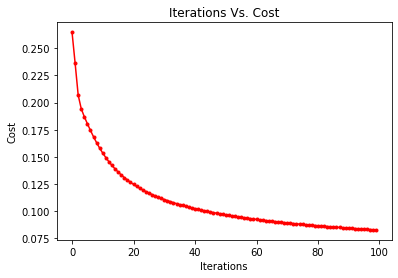

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(iterations), cost_total, '.-r')
plt.title("Iterations Vs. Cost")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

## Let's test some values:
Suppose we had a "test" set (for this data set it's every $2^5$ combination):

In [9]:
print(w)
#We can test with a single set of values, but since there are only 2^5 possiblities, we can just test using
#Our training set
f = np.dot(w,x)
a = sigmoid(f)
c = y*np.log(a) + (1-y)*np.log(1-a)
print(c)
predictions = sigmoid(f)
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0
print("predictions: ", predictions)
print("Labels: ", y)

accuracy = (1- np.sum(np.abs(predictions-y))/y.shape[1])*100
print("Accuracy: ",accuracy)

[[13.58233438 -1.20876995 -1.03624025  4.58926448 -7.98409394]]
[[-3.55255841e-04 -3.99859010e-07 -1.49109043e+00 -4.12783141e-11
  -4.47241211e-05 -5.03315280e-08 -3.59942810e-01 -5.19584376e-12
  -3.16728579e-05 -3.56436953e-08 -2.67593974e-01 -3.67961217e-12
  -3.98681807e-06 -4.48658478e-09 -3.78928659e-02 -4.63185046e-13
  -4.48658489e-09 -3.98681807e-06 -4.63185046e-13 -3.78928659e-02
  -3.56436954e-08 -3.16728579e-05 -3.67950115e-12 -2.67593974e-01
  -5.03315281e-08 -4.47241211e-05 -5.19584376e-12 -3.59942810e-01
  -3.99859010e-07 -3.55255841e-04 -4.12783141e-11 -2.55056180e-01]]
predictions:  [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 0.]]
Labels:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 0.]]
Accuracy:  96.875


# Conclusion

If we play with the values of our input and their respective labels, the cost function decreases all the same. There are some (possible) issues with this model that are not unlike classical versions:

1. The model sometimes experienced the "vanishing gradient" issue (large values of w_i)
2. The model does not explore more layers
3. The model does not include a bias
4. The model does not include regularization
5. The runtime of the model is incredibly long for a small dataset

The solution for the first issue can be solved via `hyperparameter tuning`, so this is not a problem. $2-4$ are left to be explored since this algorithm only lays the ground work for a deep and thorough neural network algorithm. $5$ might be remidied by implementing AQC on a real quantum neural network.


One big takeaway from this project is that it seems feasible for a quantum computer to compute the proper gradients for a neural network. Our model would be equivalent to a perceptron with $5$ input nodes. We successfully replaced back-propagation via adiabatic quantum computing and identified a majority of the test/training set 